# Building Models in PyMC3

## Objectives and takeaways for notebook 2

1. PyMC3 offers a set of building blocks to construct Bayesian models, this notebook introduces them.
2. This is where some of the modelling flexibility that stems from the Bayesian approach should become clear.
3. We introduce the TrueSkill paper and model and use it as an exercise in PyMC3.

## Introduction

As noted in the previous notebooks, Bayesian inference begins with specification of a probability model relating unknown variables to data. PyMC3 provides the basic building blocks for Bayesian probability models: stochastic random variables, deterministic variables, and factor potentials.

A **stochastic random variable** is a factor whose value is not completely determined by its parents, while the value of a **deterministic random variable** is entirely determined by its parents. Most models can be constructed using only these two variable types. The third quantity, the **factor potential**, is *not* a variable but simply a
log-likelihood term or constraint that is added to the joint log-probability to modify it. 

## The FreeRV class

A stochastic variable is represented in PyMC3 by a `FreeRV` class. This structure adds functionality to Theano's `TensorVariable` class, by mixing in the PyMC `Factor` class. A `Factor` is used whenever a variable contributes a log-probability term to a model. Hence, you know a variable is a subclass of `Factor` whenever it has a `logp` method, as we saw in the previous section.

A `FreeRV` object has several important attributes:

`dshape`
:   The variable's shape.

`dsize`
:   The overall size of the variable.

`distribution`
:   The probability density or mass function that describes the distribution of the variable's values.

`logp`
:   The log-probability of the variable's current value given the values
    of its parents.

`init_value`
:   The initial value of the variable, used by many algorithms as a starting point for model fitting.

`model`
:   The PyMC model to which the variable belongs.


### Creation of stochastic random variables

There are two ways to create stochastic random variables (`FreeRV` objects), which we will call the **automatic**, and **manual** interfaces.

#### Automatic

Stochastic random variables with standard distributions provided by PyMC3 can be created in a single line using special subclasses of the `Distribution` class. For example, as we have seen, the uniformly-distributed discrete variable $switchpoint$ in the coal mining disasters model is created using the automatic interface as follows:

In [1]:
import pymc3 as pm

with pm.Model() as disaster_model:

    switchpoint = pm.DiscreteUniform('switchpoint', lower=0, upper=110)

/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Similarly, the rate parameters can automatically be given exponential priors:

In [2]:
with disaster_model:
    early_mean = pm.Exponential('early_mean', lam=1)
    late_mean = pm.Exponential('late_mean', lam=1)

PyMC includes most of the probability density functions (for continuous variables) and probability mass functions (for discrete variables) used in statistical modeling. Continuous variables are represented by a specialized subclass of `Distribution` called `Continuous` and discrete variables by the `Discrete` subclass.

The main differences between these two sublcasses are in the `dtype` attribute (`int64` for `Discrete` and `float64` for `Continuous`) and the `defaults` attribute, which determines which summary statistic to use for initial values when one is not specified ('mode' for `Discrete` and 'median', 'mean', and 'mode' for `Continuous`).

In [3]:
switchpoint.distribution.defaults

('mode',)

As we previewed in the introduction, `Distribution` has a class method `dist` that returns a probability distribution of that type, without being wrapped in a PyMC random variable object. Sometimes we wish to use a particular statistical distribution, without using it as a variable in a model; for example, to generate random numbers from the distribution. This class method allows that.

In [4]:
pm.Exponential.dist(1)

#### Manual

The uniformly-distributed discrete stochastic variable `switchpoint` in the disasters model could alternatively be created from a function that computes its log-probability as follows:

In [5]:
import theano.tensor as tt

In [6]:
import numpy as np
from pymc3.math import switch, log

with pm.Model():  

    
    def uniform_logp(value, lower=0, upper=111):
        """The switchpoint for the rate of disaster occurrence."""
        return switch((value > upper) | (value < lower), -np.inf, -log(upper - lower + 1))

    switchpoint = pm.DensityDist('switchpoint', logp=uniform_logp, dtype='int64')

In [7]:
switchpoint.logp({'switchpoint':4})

array(-4.7184987, dtype=float32)

In [8]:
switchpoint.logp({'switchpoint': 44})

array(-4.7184987, dtype=float32)

In [9]:
switchpoint.logp({'switchpoint':-1})

array(-inf, dtype=float32)

A couple of things to notice: while the function specified for the `logp` argument can be an arbitrary Python function, it must use **Theano operators and functions** in its body. This is because one or more of the arguments passed to the function may be `TensorVariables`, and they must be supported. Also, we passed the value to be evaluated by the `logp` function as a **dictionary**, rather than as a plain integer. By convention, values in PyMC3 are passed around as a data structure called a `Point`. Points in parameter space are represented by dictionaries with parameter names as they keys and the value of the parameters as the values.

To emphasize, the Python function passed to `DensityDist` should compute the *log*-density or *log*-probability of the variable. That is why the return value in the example above is `-log(upper-lower+1)` rather than `1/(upper-lower+1)`.

### Specifying Custom Distributions

Similarly, the library of statistical distributions in PyMC3 is not exhaustive, but PyMC allows for the creation of user-defined functions for an **arbitrary probability distribution**. For simple statistical distributions, the `DensityDist` function takes as an argument any function that calculates a log-probability $log(p(x))$. This function may employ other random variables in its calculation. 


Here is a simple example inspired by a blog post by Jake Vanderplas (Vanderplas, 2014), where Jeffreys priors are used to specify priors that are invariant to transformation. In the case of simple linear regression, these are:

$$\beta \propto (1+\beta^2)^{3/2}$$

$$\sigma \propto \frac{1}{\alpha}$$

The logarithms of these functions can be specified as the argument to DensityDist and inserted into the model.

```python
import theano.tensor as T
from pymc3 import DensityDist, Uniform

with Model() as model:
    alpha = Uniform('intercept', -100, 100)
    
    # Create custom densities
    beta = DensityDist('beta', lambda value: -1.5 * T.log(1 + value**2), testval=0)
    eps = DensityDist('eps', lambda value: -T.log(T.abs_(value)), testval=1)
    
    # Create likelihood
    like = Normal('y_est', mu=alpha + beta * X, sd=eps, observed=Y)
```

For more complex distributions, one can create a subclass of `Continuous` or `Discrete` and provide the custom `logp` function, as required. This is how the built-in distributions in PyMC are specified. As an example, fields like psychology and astrophysics have complex likelihood functions for a particular process that may require numerical approximation. In these cases, it is impossible to write the function in terms of predefined theano operators and we must use a custom theano operator using `as_op` or inheriting from `theano.Op`. 

Implementing the `beta` variable above as a `Continuous` subclass is shown below, along with a sub-function using the `as_op` decorator, though this is not strictly necessary.

In [10]:
from pymc3.distributions import Continuous
import theano.tensor as tt
from theano import as_op

class Beta(Continuous):
    def __init__(self, mu, *args, **kwargs):
        super(Beta, self).__init__(*args, **kwargs)
        self.mu = mu
        self.mode = mu

    def logp(self, value):
        mu = self.mu
        return beta_logp(value - mu)
    
@as_op(itypes=[tt.dscalar], otypes=[tt.dscalar])
def beta_logp(value):
    return -1.5 * np.log(1 + (value)**2)


with pm.Model() as model:
    beta = Beta('slope', mu=0, testval=0)

## The ObservedRV Class

Stochastic random variables whose values are observed (*i.e.* data likelihoods) are represented by a different class than unobserved random variables. A `ObservedRV` object is instantiated any time a stochastic variable is specified with data passed as the `observed` argument. 

Otherwise, observed stochastic random variables are created via the same interfaces as unobserved: **automatic** or **manual**. As an example of an automatic instantiation, consider a Poisson data likelihood :

In [11]:
with disaster_model:
    
    disasters = pm.Poisson('disasters', mu=3, observed=[3,4,1,2,0,2,2])

We have already seen manual instantiation, from the melanoma survial model where the exponential survival likelihood was implemented manually:

```python
def logp(failure, value):
    return (failure * log(lam) - lam * value).sum()

x = DensityDist('x', logp, observed={'failure':failure, 'value':t})
```

Notice in this example that there are two vetors observed data for the likelihood `x`, passed as a dictionary.

An important responsibility of `ObservedRV` is to automatically handle missing values in the data, when they are present (absent?). More on this later.

## Deterministic Variables

A deterministic variable is one whose values are **completely determined** by the values of their parents. For example, in our disasters model, `rate` is a deterministic variable.

In [12]:
with disaster_model:
    
    rate = pm.Deterministic('rate', switch(switchpoint >= np.arange(112), early_mean, late_mean))

so `rate`'s value can be computed exactly from the values of its parents `early_mean`, `late_mean` and `switchpoint`.

There are two types of deterministic variables in PyMC3

#### Anonymous deterministic variables

The easiest way to create a deterministic variable is to operate on or transform one or more variables in a model directly. For example, the simplest way to specify the `rate` variable above is as follows:

In [13]:
with disaster_model:
    
    rate = switch(switchpoint >= np.arange(112), early_mean, late_mean)

Or, let's say we wanted to use the mean of the `early_mean` and `late_mean` variables somehere in our model:

In [14]:
with disaster_model:
    
    diff_means = pm.Deterministic('diff_means', early_mean - late_mean)

These are called *anonymous* variables because we did not wrap it with a call to `Determinstic`, which gives it a name as its first argument. We simply specified the variable as a Python (or, Theano) expression. This is therefore the simplest way to construct a determinstic variable. The only caveat is that the values generated by anonymous determinstics at every iteration of a MCMC algorithm, for example, are not recorded to the resulting trace. So, this approach is only appropriate for intermediate values in your model that you do not wish to obtain posterior estimates for, alongside the other variables in the model.

#### Named deterministic variables

To ensure that deterministic variables' values are accumulated during sampling, they should be instantiated using the **named deterministic** interface; this uses the `Deterministic` function to create the variable. Two things happen when a variable is created this way:

1. The variable is given a name (passed as the first argument)
2. The variable is appended to the model's list of random variables, which ensures that its values are tallied.


```python
with disaster_model:
    
    rate = pm.Deterministic('rate', switch(switchpoint >= np.arange(112), early_mean, late_mean))
```

In [15]:
disaster_model.named_vars

{'diff_means': diff_means,
 'disasters': disasters,
 'early_mean': early_mean,
 'early_mean_log__': early_mean_log__,
 'late_mean': late_mean,
 'late_mean_log__': late_mean_log__,
 'rate': rate,
 'switchpoint': switchpoint}

## Factor Potentials

For some applications, we want to be able to modify the joint density by incorporating terms that don't correspond to probabilities of variables conditional on parents, for example:

$$p(x_0, x_2, \ldots x_{N-1}) \propto \prod_{i=0}^{N-2} \psi_i(x_i, x_{i+1})$$

In other cases we may want to add probability terms to existing models. For example, suppose we want to constrain the difference between the early and late means in the disaster model to be less than 1, so that the joint density becomes: 

$$p(y,\tau,\lambda_1,\lambda_2) \propto p(y|\tau,\lambda_1,\lambda_2) p(\tau) p(\lambda_1) p(\lambda_2) I(|\lambda_2-\lambda_1| \lt 1)$$

We call such log-probability terms **factor potentials** (Jordan 2004). Bayesian
hierarchical notation doesn't accomodate these potentials. 

### Creation of Potentials

A potential can be created via the `Potential` function, in a way very similar to `Deterministic`'s named interface:

In [16]:
with disaster_model:
    
    rate_constraint = pm.Potential('rate_constraint', switch(pm.math.abs_(early_mean-late_mean)>1, -np.inf, 0))

The function takes just a `name` as its first argument and an expression returning the appropriate log-probability as the second argument.

A common use of a factor potential is to represent an observed likelihood, where the **observations are partly a function of model variables**. In the contrived example below, we are representing the error in a linear regression model as a zero-mean normal random variable. Thus, the "data" in this scenario is the residual, which is a function both of the data and the regression parameters.

Note that in the future, factor potentials will be key in studying *probabilistic graphical models*, which can in some cases be built from *factor graphs* (= products of factor potentials).  Thus getting familiar with the concept will also help us in the future.

In [17]:
y = np.array([15, 10, 16, 11, 9, 11, 10, 18, 11])
x = np.array([1, 2, 4, 5, 6, 8, 19, 18, 12])

with pm.Model() as arma_model:

    sigma = pm.HalfCauchy('sigma', 5)
    beta = pm.Normal('beta', 0, sd=2)
    mu = pm.Normal('mu', 0, sd=10)

    err = y - (mu + beta*x)
                  
    like = pm.Potential('like', pm.Normal.dist(0, sd=sigma).logp(err))

## Exercises

In the following, we examine a Gaussian Mixture model from the [PyMC3 documentation page](http://docs.pymc.io/notebooks/gaussian_mixture_model.html)

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt

%matplotlib inline
sns.set_context('paper')
sns.set_style('darkgrid')

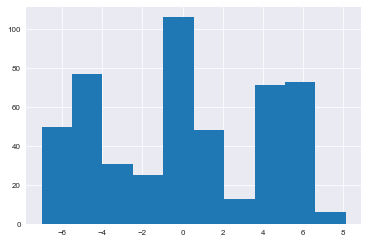

In [19]:
# simulate data from a known mixture distribution
np.random.seed(12345) # set random seed for reproducibility

# number of clusters, distance of centers
k, spread = 3, 5
ndata = 500
centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution
v = np.random.randint(0, k, ndata)
data = centers[v] + np.random.randn(ndata)

plt.hist(data);

In [20]:
# setup model
with pm.Model() as model:
    
    # cluster sizes
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=k)
    
    # ensure all clusters have at least 10% points
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))

    # cluster centers
    means = pm.Normal('means', mu=[0, 0, 0], sd=15, shape=k)
    
    # break symmetry
    order_means_potential = pm.Potential('order_means_potential',
                                         tt.switch(means[1]-means[0] < 0, -np.inf, 0)
                                         + tt.switch(means[2]-means[1] < 0, -np.inf, 0))

    # measurement error
    sd = pm.Uniform('sd', lower=0, upper=20)

    # latent cluster of each observation
    category = pm.Categorical('category',
                              p=p,
                              shape=ndata)

    # likelihood for each observed value
    points = pm.Normal('obs',
                       mu=means[category],
                       sd=sd,
                       observed=data)

In [21]:
# fit model
with model:
    step1 = pm.Metropolis(vars=[p, sd, means])
    step2 = pm.ElemwiseCategorical(vars=[category], values=[0,1,2])
    tr = pm.sample(draws=10000, step=[step1, step2])

/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  after removing the cwd from sys.path.
100%|██████████| 10500/10500 [01:40<00:00, 104.15it/s]


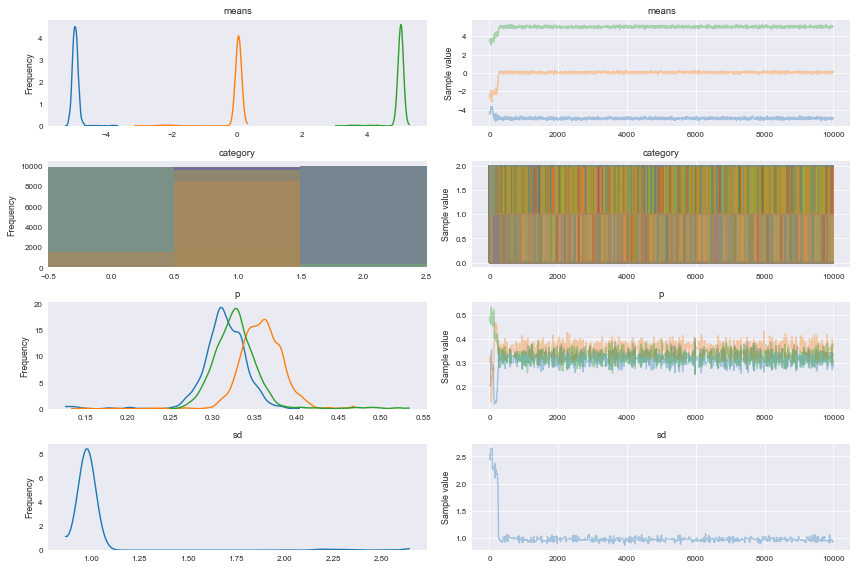

In [22]:
_ = pm.traceplot(tr)

## TrueSkill

### Backstory
One of the cool things done with Bayesian modelling was the construction of the [TrueSkill system](https://www.microsoft.com/en-us/research/publication/trueskilltm-a-bayesian-skill-rating-system/) for Microsoft Xbox online gaming platform by Ralf Herbrich and Tom Minka from Microsoft Research.  The objective of TrueSkill is simple: as quickly as possible match a player with players of similar skill with whom it will be most fun to play. Handle team play.  To reach this objective, the TS system must estimate each players quality as fast as possible.  This is done in real-time using expectation propagation (not in scope of this tutorial), and the [paper](https://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system.pdf) shows the results compared to e.g. chess ELO - and they're impressive.

**Note**: if you read the paper, note that it builds a massive PGM (probabilistic graphical model) that reflects all players and does approaximate inference via message passing - this is a variational approach for probabilistic graphical models. This will be the subject of further preparations and workshops.  However the paper discusses how the total probability distribution is built as a product of **factors** which is the subject of this exercise.  Reading the paper should give you a view of where we want to go in the (near) future.

### An example from the TrueSkill paper

Let us model the example from the TrueSkill paper, which shows an update after one game played.  Instead of using message passing, we will build the model using PyMC3.

The TrueSkill approach models team play as follows:
- Players $i \in I=\{1, .., n\}$ are partitioned into teams $A_i \subset I$, which are (of course) pairwise disjoint.
- Each player has a *skill* $s_i \sim {\cal N}(\mu_i, \sigma_i^2)$
- The **skill** results in a given **performance** during a game $p_i \sim {\cal N}(s_i, \beta^2)$
- The total performance of team $j$ is $t_j = \sum_{i \in A_j} s_i$.
- The game outcome is controlled by the difference in team performance $d = t_i-t_j$ depending on which teams we are comparing.
- The paper posits a strategy of updating parameters depending on win/tie/loss which happens depending on differences in the team performance differences as compared to a parameter $\epsilon$.  if $t_i-t_j > \epsilon$ the model predicts a win of team $t_i$, the converse is true and if $|t_i-t_j| \leq \epsilon$, then the model predicts a draw. Anything else is a surprise outcome.

Instead of the actual functions used in TrueSkill, we propose a simplified strategy that is easier to implement:
- if $t_i - t_j > \epsilon$, then $t_i$ wins with probability 90%, there is a draw with 9% probability and with 1% probability, team $i$ loses
- if $|t_i - t_j| <= \epsilon$, then $t_i$ and $t_j$ draw with 90% and win/lose situations (i.e. the complement) constitute 10%

In our example, let us fix $I=\{1,2,3,4\}$ with three teams $A_1 =\{1\}, A_2=\{2,3\}, A_3=\{4\}$.  Let us assume that after the game ends, team $A_1$ has first place while teams $A_2$ and $A_3$ tied for second place.

Let us assume that the prior for the skill of each player is ${\cal N}(25, 25/3)$ and that the draw margin is $\epsilon=3$.  Let us assume that $\beta=5$.

The model can then be constructed for example as follows

In [23]:
with pm.Model() as trueskill:
    
    mu0, sigma0 = 25., 25./3
    beta = 5.
    epsilon = 3
    
    s1 = pm.Normal('s1', mu0, sd=sigma0)
    s2 = pm.Normal('s2', mu0, sd=sigma0)
    s3 = pm.Normal('s3', mu0, sd=sigma0)
    s4 = pm.Normal('s4', mu0, sd=sigma0)
    
    p1 = pm.Normal('p1', s1, sd=beta)
    p2 = pm.Normal('p2', s2, sd=beta)
    p3 = pm.Normal('p3', s3, sd=beta)
    p4 = pm.Normal('p4', s4, sd=beta)
        
    # add 'observed likelihood' factors here, note that function should return logp
    pm.Potential('t1_win_against_t2', switch(pm.math.ge(p1 - p2 - p3, epsilon), np.log(0.9),
                                             switch(pm.math.ge(p1 - p2 - p3, epsilon), np.log(0.01), np.log(0.09))))

    pm.Potential('t2_draw_t3', switch(pm.math.le(pm.math.abs_(p2+p3 - p4), epsilon), np.log(0.9), np.log(0.1)))


Let us examine the MAP point estimate to check what happens to the individual player skills after the four games have been observed.

In [29]:
from scipy import optimize

with trueskill:
    model_map = pm.find_MAP(method='Powell')
    
model_map

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/vejmelka/Packages/anaconda/envs/bayes/lib/python3.6/site-packages/scipy/optimize/_minimize.py:415: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
logp = -26.981, ||grad|| = 1.616e-08: 100%|██████████| 274/274 [00:00<00:00, 1195.12it/s]  


{'p1': array(25.),
 'p2': array(24.99999992),
 'p3': array(25.00000021),
 'p4': array(25.),
 's1': array(25.00000016),
 's2': array(24.99999994),
 's3': array(25.),
 's4': array(25.)}

What happened? And now let us look at the posterior distribution.

In [25]:
with trueskill:
    trace = pm.sample(draws=25000, tune=5000, step=pm.Metropolis())

100%|██████████| 30000/30000 [00:34<00:00, 864.11it/s]


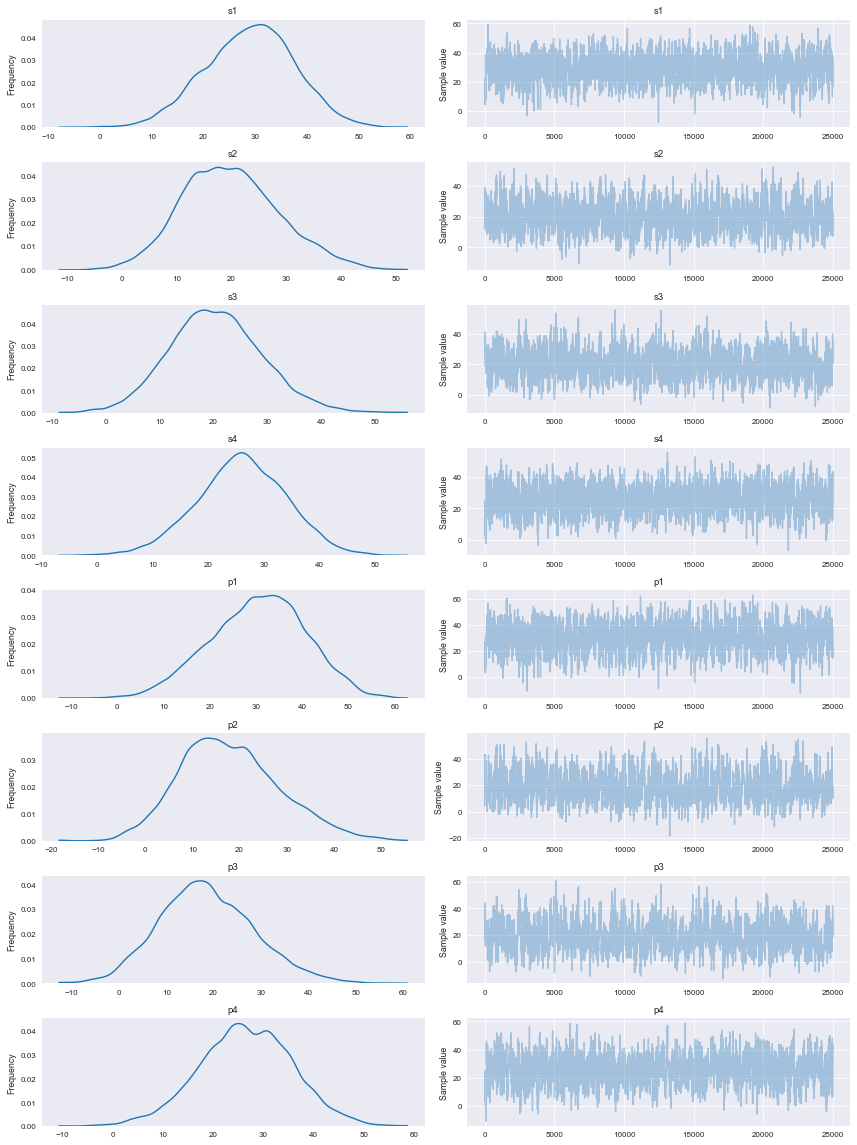

In [26]:
_ = pm.traceplot(trace)

In [27]:
pm.summary(trace, varnames=['s1', 's2', 's3', 's4'])


s1:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  28.970           8.569            0.286            [11.181, 44.223]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  11.862         23.178         29.300         34.896         45.212


s2:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  19.883           8.845            0.354            [3.223, 37.697]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  3.862          13.569         19.405         25.551         38.520


s3:

  Mean             SD               MC Error         95% HPD interval
  -----------------------------

Above, we have inferred changes to the players' skills after observing the four games.

### Question
- What would happen if the prior for one of the players was tighter (smaller variance)?  This could happen if we have already seen this player playing someone else before and we thus have more information about her.

Modify the model and examine what happens.

## Exercise

Assume that instead of observing game score differences, you only observe who wins and/or loses the game.  How would you modify the model for this new situation?

You observe only $[-1, 0, 1]$, which stands for player 1 loss, draw, player 1 win.  Build a plausible model for this situation. The goal would be to still try and estimate differences in skills.

1. How would you conceptually even approach this problem?
2. How would you implement your approach in PyMC3?  Modify the above model.
3. How would you model this with three players? What problems do you see assuming that the number of players would increase?

## References

1. Ching & Chen. 2007. Transitional Markov chain Monte Carlo method for Bayesian model updating, model class selection and model averaging. Journal of Engineering Mechanics 2007
2.	Hoffman MD, Gelman A. 2014. The No-U-turn sampler: adaptively setting path lengths in Hamiltonian Monte Carlo. The Journal of Machine Learning Research. 15(1):1593-1623.
3. M.I. Jordan. 2004. Graphical models. Statist. Sci., 19(1):140–155.
4. Neal, R. M. 2003. Slice sampling. The Annals of Statistics, 31(3), 705–767. doi:10.1111/1467-9868.00198
5. VanderPlas, J. (2014). Frequentism and bayesianism: A python-driven primer. arXiv preprint arXiv:1411.5018.
6. Herbrich, Minka and Graepel. [TrueSkill™: A Bayesian Skill Rating System](https://papers.nips.cc/paper/3079-trueskilltm-a-bayesian-skill-rating-system), NIPS 2006.